In [ ]:

!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"david123web","key":"ff634a92806dd060d9cda9630b0a75ed"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


     |████████████████████████████████| 61kB 7.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=72cc4cd53838968bcb64d7229f958e43063bd94830b4e6c953e8e8d21c0fe9e0
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 91% 259M/285M [00:01<00:00, 263MB/s]
100% 285M/285M [00:01<00:00, 245MB/s]


In [ ]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!rm -rf /content/train.csv /content/test.csv /content/icml_face_data.csv /content/example_submission.csv /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!tar -xzf /content/fer2013.tar.gz
!mkdir dataset
!mkdir dataset/fer2013
!mv /content/fer2013/fer2013.csv /content/dataset/fer2013
!rm -rf /content/fer2013 /content/fer2013.tar.gz

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class dataset_provider(object):
    def __init__(self, dataset_name, image_size):
        self.dataset_name = dataset_name
        self.image_size = image_size
        self.dataset_path = '/content/dataset/fer2013/fer2013.csv'

    def dataset_initializer(self):
        data = pd.read_csv(self.dataset_path)
        pixels = data['pixels'].tolist()
        width = 48
        height = 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'), self.image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

def get_labels(dataset_name):
    if dataset_name == 'fer2013':
        return {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
    else:
        raise Exception('Invalid args: Wrong dataset name.')


def get_class_to_arg(dataset_name):
    if dataset_name == 'fer2013':
        return {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
    else:
        raise Exception('Invalid args: Wrong dataset name.')


def pre_process(x, _is=True):
    x = x.astype('float32')
    x = x / 255.0
    if _is:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
data = pd.read_csv('/content/dataset/fer2013/fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
get_labels('fer2013')

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'sad',
 5: 'surprise',
 6: 'neutral'}

In [ ]:
pd.get_dummies(data['emotion'])

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
35882,0,0,0,0,0,0,1
35883,0,0,0,1,0,0,0
35884,1,0,0,0,0,0,0
35885,0,0,0,1,0,0,0


In [ ]:
pd.get_dummies(data['emotion']).values

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
input_shape = (64, 64, 1)
dataset = dataset_provider('fer2013', image_size=input_shape[:2])
faces, emotions = dataset.dataset_initializer()
faces = pre_process(faces)
n_train = int(0.8 * len(faces))
n_test = len(faces) - n_train
ds_train_faces= faces[:n_train]
ds_train_emotions=emotions[:n_train]
ds_test_faces=faces[n_train:]
ds_test_emotions=emotions[n_train:]
val_data=(ds_test_faces,ds_test_emotions)

In [ ]:
ds_train_faces[0]
ds_train_faces[0].shape

(64, 64, 1)

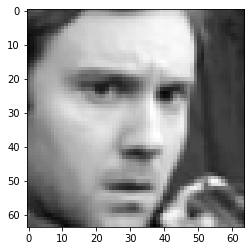

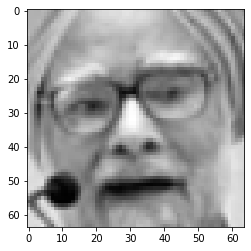

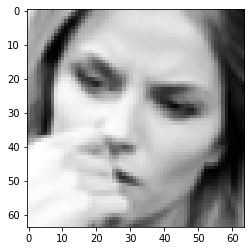

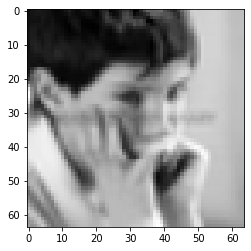

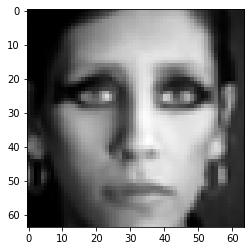

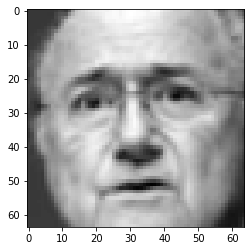

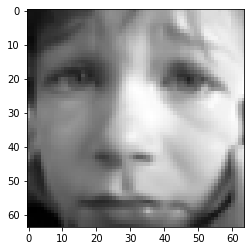

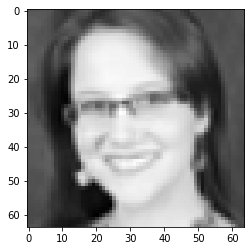

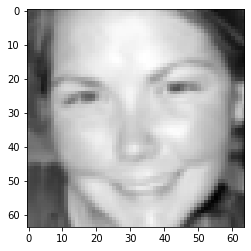

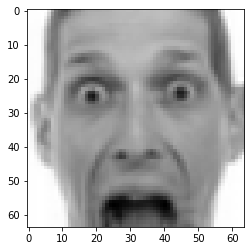

In [ ]:
for i in ds_train_faces[:10]:
  plt.imshow(np.squeeze(i),'gray')
  plt.show()

In [ ]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras
from keras.preprocessing import image

In [ ]:
def emotion_model(input_shape, classes_no):
  input_data = keras.layers.Input(input_shape)
  model = keras.layers.Convolution2D(8,(3,3))(input_data)
  model = keras.layers.BatchNormalization()(model)
  model = keras.layers.Activation('relu')(model)
  my_filters = [16,64,256,512]
  for filter in my_filters:
    model = keras.layers.Convolution2D(filter,(3,3),padding='same')(model)
    model = keras.layers.BatchNormalization()(model)
    model = keras.layers.Activation('relu')(model)
    model = keras.layers.Convolution2D(filter,(3,3),padding='same')(model)
    model = keras.layers.BatchNormalization()(model)
    model = keras.layers.MaxPooling2D(pool_size=(2,2), padding='same')(model)
    model = keras.layers.Activation('relu')(model)
  model = keras.layers.Convolution2D(classes_no,(3,3),padding='same')(model)
  model = keras.layers.GlobalMaxPooling2D()(model)
  ret_model = keras.models.Model(input_data, keras.layers.Activation('softmax',name='predictions')(model))
  return ret_model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


# parameters
input_shape=(64,64,1)

#callbacks
early_stop=EarlyStopping('val_loss', patience=50)
reduce_lr=ReduceLROnPlateau('val_loss', factor=0.1, patience=int(50/4), verbose=1)
callbacks=[early_stop, reduce_lr]
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# model parameters/compilation
model = emotion_model(input_shape, 7)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# loading dataset
model.fit_generator(data_generator.flow(ds_train_faces, ds_train_emotions,
                                            32),
                        steps_per_epoch=len(ds_train_faces) / 32,
                        epochs=100, verbose=1,callbacks=callbacks, validation_data=val_data)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
897/897 [==============================] - 58s 28ms/step - loss: 2.0167 - accuracy: 0.2555 - val_loss: 3.6157 - val_accuracy: 0.3192
Epoch 2/100
897/897 [==============================] - 24s 26ms/step - loss: 1.5077 - accuracy: 0.4090 - val_loss: 1.3435 - val_accuracy: 0.4861
Epoch 3/100
897/897 [==============================] - 24s 26ms/step - loss: 1.3076 - accuracy: 0.4994 - val_loss: 1.2194 - val_accuracy: 0.5358
Epoch 4/100
897/897 [==============================] - 24s 27ms/step - loss: 1.2027 - accuracy: 0.5469 - val_loss: 1.1908 - val_accuracy: 0.5433
Epoch 5/100
897/897 [==============================] - 24s 27ms/step - loss: 1.1299 - accuracy: 0.5730 - val_loss: 1.1254 - val_accuracy: 0.5773
Epoch 6/100
897/897 [==============================] - 24s 27ms/step - loss: 1.0814 - accuracy: 0.5957 - val_loss: 1.3794 - val_accuracy: 0.4915
Epoch 7/100
897/897 [==============================] - 24s 27ms/step - loss: 1.0502 - accuracy: 0.6061 - val_loss: 1.0698 - val_ac

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

INFO:tensorflow:Assets written to: emotion_detection.model/assets


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [ ]:
def detect_face(cascade, pic, scaleFactor=1.3):
  #incase we change the original one
  img=pic.copy()
  #convert image into gray scale as opencv face detector expects gray images
  gray_image=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  
  #use haar classifier to detect faces
  face_box=cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
  

  cropped=[]
  xs=[]
  ys=[]
  for(x,y,w,h) in face_box:
    cv2.rectangle(img, (x,y), (x+w, y+h+10), (0,255,0), 2)
    #crop the boxed face
    gray_frame=gray_image[y:y+h,x:x+w]
    cropped_img = cv2.resize(gray_frame, (48,48))
    cropped_img = image.img_to_array(cropped_img)
    cropped_img = cv2.resize(cropped_img.astype('uint8'), (64,64))
    cropped_img = cropped_img.astype('float32')
    cropped_img = ((cropped_img / 255.0) - 0.5) * 2.0
    cropped_img = np.expand_dims(cropped_img, 0)
    cropped_img = np.expand_dims(cropped_img,-1)
    cropped.append(cropped_img)
    xs.append(x)
    ys.append(y)
    
  return xs, ys, img, cropped


In [ ]:
emotion_lib = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
test_image=cv2.imread('/happy.jpg')

In [ ]:
cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

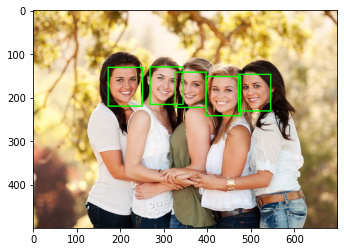

In [ ]:
x, y, face, crop=detect_face(cascade, test_image)
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))


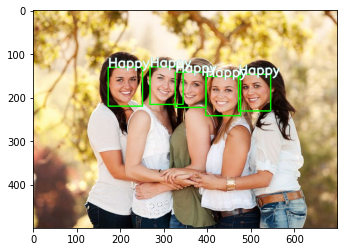

In [ ]:
j=0
for i in crop:
  emotion_pred=int(np.argmax(loaded_model.predict(i)))
  cv2.putText (face, emotion_lib[emotion_pred], (x[j], y[j]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255,255), 2, cv2.LINE_AA)
  j+=1

plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
  

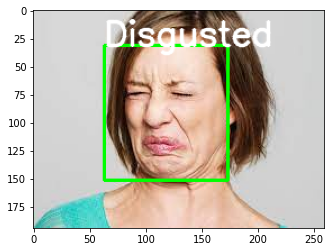

In [ ]:
test_image=cv2.imread('/disgusted.jpg')
cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
x, y, face, crop=detect_face(cascade, test_image)
j=0
for i in crop:
  emotion_pred=int(np.argmax(loaded_model.predict(i)))
  cv2.putText (face, emotion_lib[emotion_pred], (x[j], y[j]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
  j+=1

plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))